# Variational Auto-Encoder (VAE)

### Zhenwen Dai (2018-8-21)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import mxfusion as mf
import mxnet as mx
import numpy as np
import mxnet.gluon.nn as nn
import mxfusion.components
import mxfusion.inference
%matplotlib inline
from pylab import *

## Load a toy dataset

In [2]:
import GPy
data = GPy.util.datasets.oil_100()
Y = data['X']
label = data['Y'].argmax(1)

In [3]:
N, D = Y.shape

## Model Defintion

In [4]:
Q = 2

In [5]:
H = 50
encoder = nn.HybridSequential(prefix='encoder_')
with encoder.name_scope():
    encoder.add(nn.Dense(H, activation="tanh"))
    encoder.add(nn.Dense(H, activation="tanh"))
    encoder.add(nn.Dense(Q, flatten=True))
encoder.initialize(mx.init.Xavier(magnitude=3))
_=encoder(mx.nd.array(np.random.rand(5,D)))

In [6]:
H = 50
decoder = nn.HybridSequential(prefix='decoder_')
with decoder.name_scope():
    decoder.add(nn.Dense(H, activation="tanh"))
    decoder.add(nn.Dense(H, activation="tanh"))
    decoder.add(nn.Dense(D, flatten=True))
decoder.initialize(mx.init.Xavier(magnitude=3))
_=decoder(mx.nd.array(np.random.rand(5,Q)))

In [7]:
from mxfusion.components.variables.var_trans import PositiveTransformation

In [8]:
m = mf.models.Model()
m.N = mf.components.Variable()
m.decoder = mf.components.functions.MXFusionGluonFunction(decoder, num_outputs=1,broadcastable=False)
m.x = mf.components.distributions.Normal.define_variable(mean=mx.nd.array([0]), variance=mx.nd.array([1]), shape=(m.N, Q))
m.f = m.decoder(m.x)
m.noise_var = mf.components.Variable(shape=(1,), transformation=PositiveTransformation(), initial_value=mx.nd.array([0.01]))
m.y = mf.components.distributions.Normal.define_variable(mean=m.f, variance=m.noise_var, shape=(m.N, D))
print(m)

x ~ Normal(mean=Variable(e909c), variance=Variable(e90bf))
f = GluonFunctionEvaluation(decoder_input_0=x, decoder_dense0_weight=Variable(0f71b), decoder_dense0_bias=Variable(aee54), decoder_dense1_weight=Variable(8db61), decoder_dense1_bias=Variable(7c56e), decoder_dense2_weight=Variable(85b99), decoder_dense2_bias=Variable(21241))
y ~ Normal(mean=f, variance=noise_var)


In [9]:
q = mf.models.Posterior(m)
q.x_var = mf.components.Variable(shape=(1,), transformation=PositiveTransformation(), initial_value=mx.nd.array([1e-6]))
q.encoder = mf.components.functions.MXFusionGluonFunction(encoder, num_outputs=1, broadcastable=False)
q.x_mean = q.encoder(q.y)
q.x.set_prior(mf.components.distributions.Normal(mean=q.x_mean, variance=q.x_var))
print(q)

x_mean = GluonFunctionEvaluation(encoder_input_0=y, encoder_dense0_weight=Variable(9768f), encoder_dense0_bias=Variable(9f1a0), encoder_dense1_weight=Variable(18970), encoder_dense1_bias=Variable(bcff4), encoder_dense2_weight=Variable(3d2a8), encoder_dense2_bias=Variable(95031))
x ~ Normal(mean=x_mean, variance=x_var)


## Variational Inference

In [10]:
from mxfusion.inference import BatchInferenceLoop, StochasticVariationalInference, GradBasedInference

In [11]:
observed = [m.y]
alg = StochasticVariationalInference(num_samples=3, model=m, posterior=q, observed=observed)
infr = GradBasedInference(inference_algorithm=alg, grad_loop=BatchInferenceLoop())

In [12]:
infr.run(max_iter=2000, learning_rate=1e-2, y=mx.nd.array(Y), verbose=True)

Iteration 201 loss: 1715.0395507812525
Iteration 401 loss: 599.87670898437525
Iteration 601 loss: 149.24291992187538
Iteration 801 loss: -44.793395996093755
Iteration 1001 loss: -202.39929199218755
Iteration 1201 loss: -314.48220825195315
Iteration 1401 loss: -301.41076660156255
Iteration 1601 loss: -585.94531250937585
Iteration 1801 loss: -702.51806640625525
Iteration 2000 loss: -775.11627197265625

## Plot the training data in the latent space

In [13]:
q_x_mean = q.encoder.gluon_block(mx.nd.array(Y)).asnumpy()

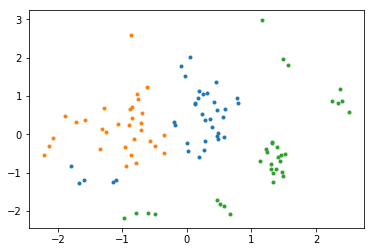

In [14]:
for i in range(3):
    plot(q_x_mean[label==i,0], q_x_mean[label==i,1], '.')